In [ ]:
!pip install -q keras

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from urllib.parse import urlparse
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding, LSTM, Bidirectional
import re
import ipaddress
from bs4 import BeautifulSoup
import requests
from keras import callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
from flask import Flask, render_template, request

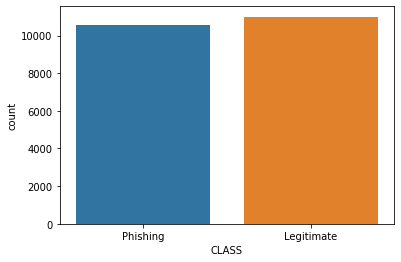

In [ ]:
df = pd.read_csv('Dataset (1).csv')
sns.countplot(df['CLASS'])
df1 = df.replace(['Phishing', 'Legitimate'], [0, 1])


In [ ]:
df1.head(20)

,URL,CLASS
0,https://linktr.ee/btinternetlee,0
1,https://tinyurl.com/3j3k2mzd,0
2,https://nevstr.weebly.com/,0
3,https://link.account-update824.com/em=,0
4,https://amazomerowihuiegarbcc.xyz/,0
5,https://filesharing-globe.web.app/,0
6,http://donmaperoebbn.com/mazon/amazon/,0
7,https://amazom.zbzsur.shop/pc,0
8,https://capri-salincak.com/AI,0
9,https://qlyervas.com.br/juridico/fatura/,0


In [ ]:
df1.tail(20)

,URL,CLASS
21561,http://caixa.gov.br/voce/poupanca-e-investimen...,1
21562,http://censor.net.ua/news/336040/pod_kievom_pr...,1
21563,http://censor.net.ua/resonance/330248/kak_russ...,1
21564,http://censor.net.ua/resonance/330643/patrul_n...,1
21565,http://censor.net.ua/resonance/332923/i_kaznil...,1
21566,http://censor.net.ua/video_news/335264/sud_pro...,1
21567,http://cheezburger.com/66567/video-games-you-h...,1
21568,http://cheezburger.com/8471871488/video-games-...,1
21569,http://clien.net/cs2/bbs/board.php?bo_table=cm...,1
21570,http://codecanyon.net/item/easy-translation-ma...,1


In [ ]:
# Checks for IP address in URL (Have_IP)
def havingIP(url):
  try:
    ipaddress.ip_address(url)
    ip = 0
  except:
    ip = 1
  return ip

# Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
  if "@" in url:
    at = 0
  else:
    at = 1
  return at

# Finding the length of URL and categorizing (URL_Length)
def getLength(url):
  if len(url) < 54:
    length =1
  else:
    length = 0
  return length

# Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def get_protocol(url):
    protocol = urlparse(url)
    if protocol.scheme == 'https':
        return 0
    else:
        return 1

# Gives number of '/' in URL (URL_Depth)
def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

# Checking for redirection '//' in the url (Redirection)
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 0
    else:
      return 1
  else:
    return 1

#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"


# Checking for Shortening Services in URL (Tiny_URL)
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 0
    else:
        return 1

# Checking for Prefix or Suffix Separated by (-) in the Domain (Prefix/Suffix)
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 0          # phishing
    else:
        return 1          # legitimate



In [ ]:
ip = []
attherate = []
url_length= []
protocol = []
singleSlash= []
doubleSlash= []
tinyurl = []
hyphen= []

In [ ]:
def extract_all_features():
  counter = 0
  for url in df['URL']:
        counter = counter + 1
        ip.append(havingIP(url))
        attherate.append(haveAtSign(url))
        url_length.append(getLength(url))
        singleSlash.append(getDepth(url))
        doubleSlash.append(redirection(url))
        protocol.append(get_protocol(url))
        hyphen.append(prefixSuffix(url))
        tinyurl.append(tinyURL(url))

In [ ]:
extract_all_features()

In [ ]:
features_df = pd.DataFrame()
features_df["IP Check"] = ip
features_df["At The Rate"] = attherate
features_df["URL Length"] = url_length
features_df["Single Slash"] = singleSlash
features_df["Double Slash"] = doubleSlash
features_df["HTTP/HTTPS"] = protocol
features_df["Hyphen "] = hyphen
features_df["Tiny URL"] = tinyurl
features_df["Class"] = df1.CLASS

In [ ]:
features_df.head(20)

,IP Check,At The Rate,URL Length,Single Slash,Double Slash,HTTP/HTTPS,Hyphen,Tiny URL,Class
0,1,1,1,1,1,0,1,1,0
1,1,1,1,1,1,0,1,0,0
2,1,1,1,0,1,0,1,1,0
3,1,1,1,1,1,0,0,1,0
4,1,1,1,0,1,0,1,1,0
5,1,1,1,0,1,0,0,1,0
6,1,1,1,2,1,1,1,1,0
7,1,1,1,1,1,0,1,1,0
8,1,1,1,1,1,0,0,1,0
9,1,1,1,2,1,0,1,1,0


In [ ]:
features_df.tail(20)

,IP Check,At The Rate,URL Length,Single Slash,Double Slash,HTTP/HTTPS,Hyphen,Tiny URL,Class
21561,1,1,0,5,1,1,1,1,1
21562,1,1,0,3,1,1,1,1,1
21563,1,1,0,3,1,1,1,1,1
21564,1,1,0,3,1,1,1,1,1
21565,1,1,0,3,1,1,1,1,1
21566,1,1,0,3,1,1,1,1,1
21567,1,1,0,2,1,1,1,1,1
21568,1,1,0,2,1,1,1,1,1
21569,1,1,0,3,1,1,1,1,1
21570,1,1,0,4,1,1,1,1,1


In [ ]:
features_df.shape

(21581, 9)

In [ ]:
X = features_df.iloc[:, 0:7].values
y = features_df.iloc[:, 7].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.seed(10))

In [ ]:
model = Sequential()
model.add(Embedding(21581, 8))
model.add(Bidirectional(LSTM(128, activation='relu', dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(128, activation='relu', dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.3)))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           172648    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        140288    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
es_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5)

In [ ]:
history = model.fit(X_train, y_train, batch_size=10, epochs=30, verbose=1, callbacks=[es_cb],validation_split=0.2)
scores = model.evaluate(X_test, y_test)

print('\nAccuracy score of Bi-LSTM Neural Network {0:.2f}%'.format(scores[1]*100))

Epoch 1/30
1382/1382 [==============================] - 98s 71ms/step - loss: 0.7246 - accuracy: 0.8976 - val_loss: 0.2714 - val_accuracy: 0.9021
Epoch 2/30
1382/1382 [==============================] - 87s 63ms/step - loss: 0.3181 - accuracy: 0.8888 - val_loss: 0.2765 - val_accuracy: 0.9073
Epoch 3/30
1382/1382 [==============================] - 86s 62ms/step - loss: 0.2924 - accuracy: 0.8959 - val_loss: 0.2645 - val_accuracy: 0.9070
Epoch 4/30
1382/1382 [==============================] - 86s 62ms/step - loss: 0.2787 - accuracy: 0.9036 - val_loss: 0.2614 - val_accuracy: 0.9070
Epoch 5/30
1382/1382 [==============================] - 86s 62ms/step - loss: 0.2694 - accuracy: 0.9030 - val_loss: 0.2565 - val_accuracy: 0.9082
Epoch 6/30
1382/1382 [==============================] - 86s 62ms/step - loss: 0.2834 - accuracy: 0.9013 - val_loss: 0.2566 - val_accuracy: 0.9088
Epoch 7/30
1382/1382 [==============================] - 86s 62ms/step - loss: 8.3501 - accuracy: 0.7674 - val_loss: 0.4591 -

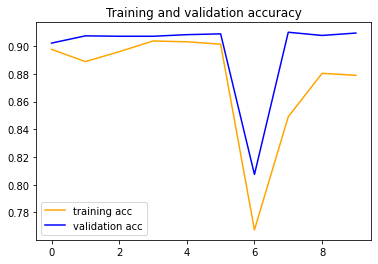

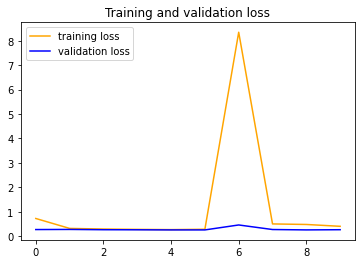

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save('model_bidi.h5')

In [ ]:
prediction=model.predict(X_test)

In [ ]:
pred = np.array([1 if i >= 0.5 else 0 for i in prediction])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score=accuracy_score(y_test,pred)*100

print(accuracy_score)

90.15520037062775


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(y_test, pred)*100}")

Precision Score of the classifier is: 87.1422469030329


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
print(f"Recall Score of the classifier is: {recall_score(y_test, pred)*100}")

Recall Score of the classifier is: 94.26987060998152


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(y_test, pred)*100}")

F1 Score of the classifier is: 90.56603773584906


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1976
           1       0.94      0.87      0.91      2341

    accuracy                           0.90      4317
   macro avg       0.90      0.90      0.90      4317
weighted avg       0.90      0.90      0.90      4317



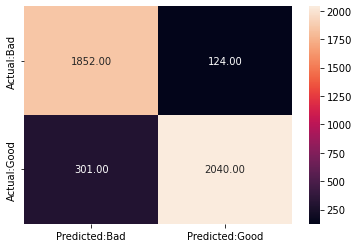

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(pred,y_test))
con  = pd.DataFrame(confusion_matrix(pred,y_test), columns = ['Predicted:Bad', 'Predicted:Good'], index = ['Actual:Bad', 'Actual:Good'])
sns.heatmap(con,annot=True,fmt='.2f')

AUC for our classifier is: 94.41504911257387


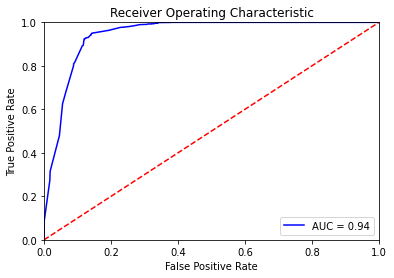

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predict_prob=model.predict(X_test)

preds = predict_prob[:]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc*100}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **PREDICTION**

In [ ]:
def generate_data_set(url):
  data_set = []

  try:
    ipaddress.ip_address(url)
    data_set.append(0)
  except:
    data_set.append(1)

  if "@" in url:
    data_set.append(0)
  else:
    data_set.append(1)

  if len(url) < 54:
    data_set.append(1)
  else:
    data_set.append(0)

  protocol = urlparse(url)
  if protocol.scheme == 'https':
    data_set.append(0)
  else:
    data_set.append(1)

  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  data_set.append(depth)

  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      data_set.append(0)
    else:
      data_set.append(1)
  else:
    data_set.append(1)

  if '-' in urlparse(url).netloc:
    data_set.append(0)
  else:
    data_set.append(1)


  shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                        r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                        r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                        r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                        r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                        r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                        r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                        r"tr\.im|link\.zip\.net"

  match=re.search(shortening_services,url)
  if match:
    data_set.append(0)
  else:
    data_set.append(1)

  return data_set

In [ ]:
url1 = "http://pidx.mo.humangrowth.pe/fhghdtafgffs/33a09772b3125829ab3db110e6de42d8/"

x = generate_data_set(url1)
x = np.array(x).reshape(1,8)
x

array([[1, 1, 0, 1, 2, 1, 1, 1]])

In [ ]:
y_pred = model.predict(x)
print(y_pred)


[[0.83231366]]


In [ ]:
if y_pred < 0.5:
    print("Predicted Class - Phishing")
else:
    print("Predicted Class - Benign")


Predicted Class - Benign


In [ ]:
url1 = "https://nevstr.weebly.com/"

x = generate_data_set(url1)
x = np.array(x).reshape(1,8)
y_pred = model.predict(x)
if y_pred < 0.5:
    print("Predicted Class - Phishing")
else:
    print("Predicted Class - Benign")


Predicted Class - Phishing


In [ ]:
url1 = "https://www.google.co.in/"

x = generate_data_set(url1)
x = np.array(x).reshape(1,8)
y_pred = model.predict(x)
if y_pred > 0.5:
    print("Predicted Class - Phishing")
else:
    print("Predicted Class - Benign")


Predicted Class - Benign


In [ ]:
url1 = "http://thenextweb.com/in/2015/05/11/bitcoin-is-the-worlds-most-dangerous-idea-really/gtm.js"

x = generate_data_set(url1)
x = np.array(x).reshape(1,8)
y_pred = model.predict(x)
if y_pred > 0.5:
    print("Predicted Class - Phishing")
else:
    print("Predicted Class - Benign")


Predicted Class - Phishing


In [ ]:
data2 = [['1','ANN','90.72','91.17','90.31','87.69','93.85','90.66','82.88'],['2','CNN','90.93','91.34','90.48','87.44','94.59','90.87','100.89'],['3','CNN+LSTM','90.86','89.92','89.9','90.09','99.58','94.60','267.81'],['4','RNN+LSTM','90.3','90.4','90.0','87.03','94.63','90.67','118.68'],['5','Bidirectional LSTM','91.4','91.3','91.15','87.14','94.26','90.56','924.388']]
df4 = pd.DataFrame(data2, columns = ['SNo.', 'DNN Algorithm Used','Training Accuracy','Validation Accuracy','Testing Accuracy', 'Precision','Recall','F1-Score','Execution Time (sec)'])
df4

,SNo.,DNN Algorithm Used,Training Accuracy,Validation Accuracy,Testing Accuracy,Precision,Recall,F1-Score,Execution Time (sec)
0,1,ANN,90.72,91.17,90.31,87.69,93.85,90.66,82.88
1,2,CNN,90.93,91.34,90.48,87.44,94.59,90.87,100.89
2,3,CNN+LSTM,90.86,89.92,89.9,90.09,99.58,94.60,267.81
3,4,RNN+LSTM,90.3,90.4,90.0,87.03,94.63,90.67,118.68
4,5,Bidirectional LSTM,91.4,91.3,91.15,87.14,94.26,90.56,924.388
